**Skin Lesion Classification: HAM10000 Dataset**
This notebook builds a deep learning model to classify skin lesions from the HAM10000 dataset into 7 categories: melanoma (mel), melanocytic nevi (nv), basal cell carcinoma (bcc), actinic keratoses (akiec), benign keratosis-like lesions (bkl), dermatofibroma (df), and vascular lesions (vasc).

**Steps**:
- Setup and explore the dataset.
- Preprocess images and handle class imbalance.
- Build and train a CNN model using EfficientNet.
- Evaluate the model and visualize results.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadshazilkhan","key":"f6cf5e491bdee6068687dc596a0c3d7e"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
# copy the kaggle.json to the kaggle folder
!cp /content/kaggle.json ~/.kaggle/

In [5]:
#permission for json to act # Set permissions to read/write only for the owner
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                        title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
jayaantanaath/student-habits-vs-academic-performance       Student Habits vs Academic Performance               19512  2025-04-12 10:49:08.663000          12141        220  1.0              
fatemehmohammadinia/heart-attack-dataset-tarik-a-rashid    Heart Attack Dataset                                 16250  2025-04-30 21:58:22.740000           1256         24  1.0              
adilshamim8/predict-students-dropout-and-academic-success  Student Dropout & Success Prediction Dataset        106181  2025-04-23 06:34:06.433000           1230         27  1.0              
rameezmeerasahib/electric-vehicle-ev-sales-an

In [6]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0


In [7]:
# Unzip the dataset
!unzip -q skin-cancer-mnist-ham10000.zip -d /content/ham10000

In [ ]:
pwd

'/content'

In [8]:
# Move images from subdirectories to /content/ham10000/
!mv /content/ham10000/ham10000_images_part_1/* /content/ham10000/
!mv /content/ham10000/ham10000_images_part_2/* /content/ham10000/


In [9]:
# Remove the empty subdirectories
!rmdir /content/ham10000/ham10000_images_part_1
!rmdir /content/ham10000/ham10000_images_part_2

Code - Install and Import Libraries

In [11]:
# Suppress TensorFlow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Install efficientnet
!pip install efficientnet --no-cache-dir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


# Verify GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 143.8 MB/s eta 0:00:00
Num GPUs Available:  1


Step 1: Load and Explore the Dataset

The HAM10000 dataset contains ~10,015 dermoscopic images and a metadata CSV file. We load the metadata and explore the distribution of diagnostic categories

Load Metadata and Visualize Distribution

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   diagnosis     10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB
None

Diagnosis Distribution:
diagnosis
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64


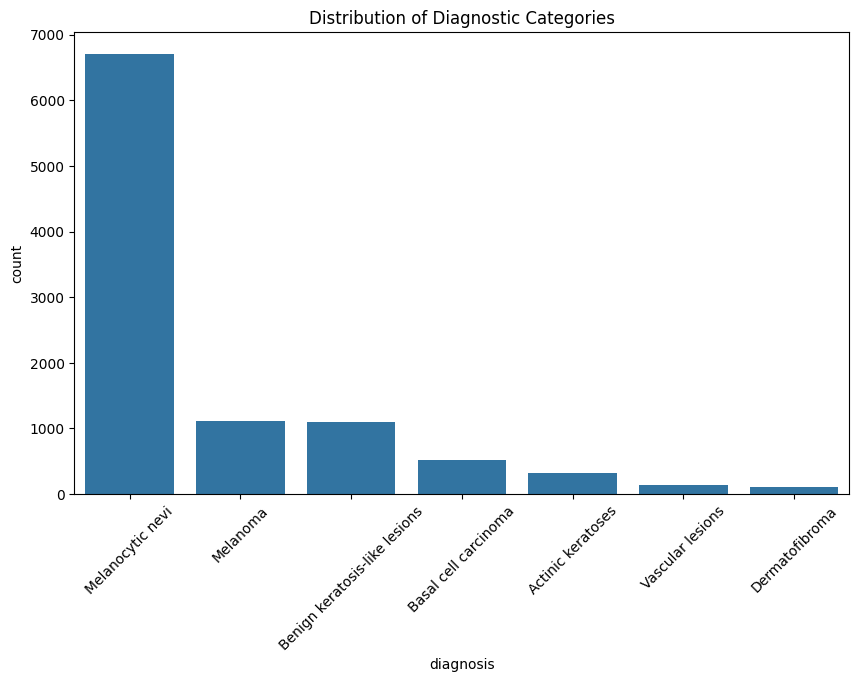

In [12]:
# Define paths
base_dir = '/content/ham10000/'
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')
image_dir = base_dir  # Images are directly in /content/ham10000/

# Load metadata
df = pd.read_csv(metadata_path)

# Map diagnosis codes to human-readable labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
df['diagnosis'] = df['dx'].map(lesion_type_dict)

# Display basic info
display(df.head())
print("Dataset Info:")
print(df.info())
print("\nDiagnosis Distribution:")
print(df['diagnosis'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='diagnosis', data=df, order=df['diagnosis'].value_counts().index)
plt.title('Distribution of Diagnostic Categories')
plt.xticks(rotation=45)
plt.show()

Step2: Load Dataset and Create Binary Labels

In [19]:
# Load metadata
metadata_path = os.path.join(base_dir, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_path)

# Add image paths to DataFrame
def get_image_path(image_id):
    return os.path.join(base_dir, f"{image_id}.jpg")

df['image_path'] = df['image_id'].apply(get_image_path)

# Add binary label for malignant vs. benign
malignant_classes = ['akiec', 'bcc', 'mel']
df['malignant'] = df['dx'].apply(lambda x: 1 if x in malignant_classes else 0)

# Convert malignant column to strings
df['malignant'] = df['malignant'].astype(str)

# Split data: 80% train, 10% validation, 10% test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['malignant'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['malignant'], random_state=42)

# Verify dataset
image_count = len([f for f in os.listdir(base_dir) if f.endswith('.jpg')])
metadata_exists = os.path.exists(metadata_path)

print(f"\nFound {image_count} image files in {base_dir}")
print(f"Train: {len(train_df)} images, Validation: {len(val_df)} images, Test: {len(test_df)} images")
print(f"Train Malignant: {train_df['malignant'].eq('1').mean():.2%}, Validation Malignant: {val_df['malignant'].eq('1').mean():.2%}, Test Malignant: {test_df['malignant'].eq('1').mean():.2%}")
if metadata_exists:
    print("Metadata file found: HAM10000_metadata.csv")
else:
    print(f"Warning: HAM10000_metadata.csv not found in {base_dir}.")

print(f"\nSample files in {base_dir}:")
!ls {base_dir} | head -n 5

if image_count >= 10000 and metadata_exists:
    print(f"Dataset setup complete. Images and metadata are in {base_dir}")
else:
    print(f"Dataset setup incomplete. Ensure ~10,015 images and HAM10000_metadata.csv are in {base_dir}")


Found 10015 image files in /content/ham10000/
Train: 8012 images, Validation: 1001 images, Test: 1002 images
Train Malignant: 19.51%, Validation Malignant: 19.48%, Test Malignant: 19.56%
Metadata file found: HAM10000_metadata.csv

Sample files in /content/ham10000/:
HAM10000_images_part_1
HAM10000_images_part_2
HAM10000_metadata.csv
hmnist_28_28_L.csv
hmnist_28_28_RGB.csv
Dataset setup complete. Images and metadata are in /content/ham10000/


### Set Up Data Generators

In [20]:
# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Data generator for validation/test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='malignant',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='malignant',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='malignant',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Verify generators
print(f"Train Generator Classes: {train_generator.class_indices}")
print(f"Validation Generator Classes: {val_generator.class_indices}")
print(f"Test Generator Classes: {test_generator.class_indices}")

Found 8012 validated image filenames belonging to 2 classes.
Found 1001 validated image filenames belonging to 2 classes.
Found 1002 validated image filenames belonging to 2 classes.
Train Generator Classes: {'0': 0, '1': 1}
Validation Generator Classes: {'0': 0, '1': 1}
Test Generator Classes: {'0': 0, '1': 1}


### Define Model and Compute Class Weights
#### Defines the model using EfficientNetB0 and computes class weights for the binary problem.

In [23]:
# Compute class weights for binary classification
train_labels = train_df['malignant'].values.astype(int)
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = dict(zip(classes, class_weights))
print("Initial Class Weights:", class_weight_dict)

# Adjust weights for malignant class
class_weight_dict[1] *= 1.5  # Increase weight for malignant class
print("Adjusted Class Weights:", class_weight_dict)

# Load pretrained EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Fixed: Apply the Dense layer to x

# Create model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Initial Class Weights: {np.int64(0): np.float64(0.6211815785393084), np.int64(1): np.float64(2.563019833653231)}
Adjusted Class Weights: {np.int64(0): np.float64(0.6211815785393084), np.int64(1): np.float64(3.844529750479847)}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 112, 112,  │      1,536 │ block1a_project_… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 112, 112,  │        384 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 112, 112,  │          0 │ block2a_expand_b

 Total params: 4,705,949 (17.95 MB)

 Trainable params: 656,385 (2.50 MB)

 Non-trainable params: 4,049,564 (15.45 MB)

### Train the Model

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 211s 751ms/step - accuracy: 0.6279 - loss: 0.7161 - val_accuracy: 0.6144 - val_loss: 0.7526
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 640ms/step - accuracy: 0.6832 - loss: 0.6165 - val_accuracy: 0.7063 - val_loss: 0.5555
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 158s 630ms/step - accuracy: 0.6781 - loss: 0.6034 - val_accuracy: 0.7572 - val_loss: 0.4576
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 618ms/step - accuracy: 0.7016 - loss: 0.5833 - val_accuracy: 0.7083 - val_loss: 0.5305
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 619ms/step - accuracy: 0.6994 - loss: 0.5651 - val_accuracy: 0.7083 - val_loss: 0.5336
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 623ms/step - accuracy: 0.6900 - loss: 0.5887 - val_accuracy: 0.7592 - val_loss: 0.4382
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 155s 616ms/step - accuracy: 0.6982 - loss: 0.5689 - val_accuracy: 0.7323 - val_loss: 0.4664
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 638ms/step - accuracy: 0.7013 -

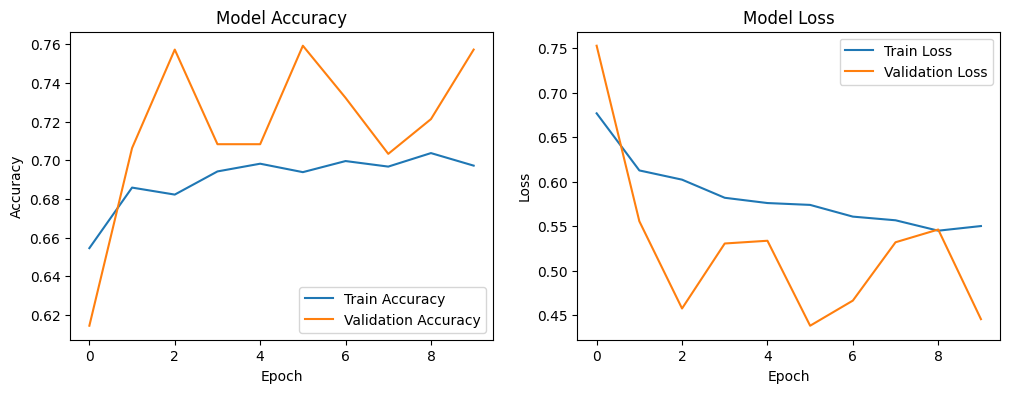

In [24]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight_dict
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Evaluate The Model

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 405ms/step - accuracy: 0.7190 - loss: 0.4888
Test Loss: 0.4956, Test Accuracy: 0.7166
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 392ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.68      0.79       806
   Malignant       0.40      0.87      0.54       196

    accuracy                           0.72      1002
   macro avg       0.68      0.77      0.67      1002
weighted avg       0.85      0.72      0.75      1002



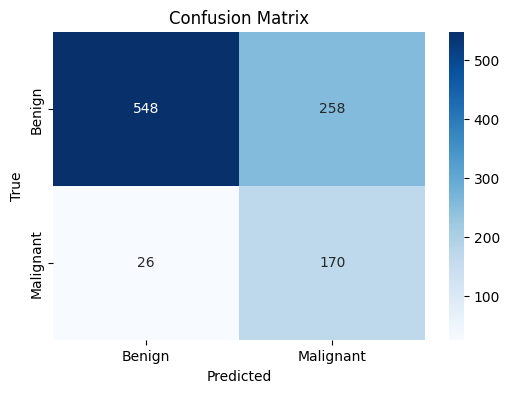

In [25]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_test_pred = model.predict(test_generator)
y_test_pred_classes = (y_test_pred > 0.5).astype(int).flatten()
y_test_true = test_generator.labels

# Classification report
class_names = ['Benign', 'Malignant']
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Save the Model

In [26]:
# Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# Define the save path in Google Drive
model_save_path = '/content/drive/MyDrive/ham10000/skin_lesion_classifier_binary.h5'

# Save the model
model.save(model_save_path)
print(f"Model saved as '{model_save_path}'")

Mounted at /content/drive
Model saved as '/content/drive/MyDrive/ham10000/skin_lesion_classifier_binary.h5'


### Evaluate on the Given Image

Mounted at /content/drive


Model loaded from /content/drive/MyDrive/ham10000/skin_lesion_classifier_binary.h5
Please upload an image for classification:


Saving sample_image.png to sample_image.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


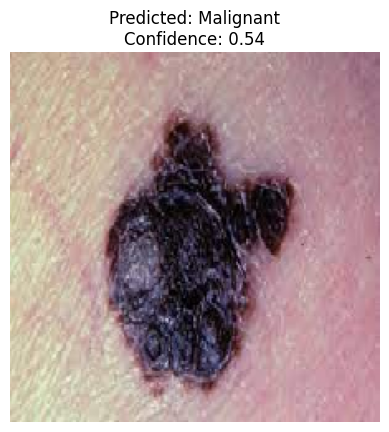

Predicted class: Malignant
Confidence: 0.54
Malignant Probability: 0.54


In [27]:
# Define custom objects
def swish(x):
    return tf.nn.swish(x)

class FixedDropout(Dropout):
    def __init__(self, rate, noise_shape=None, seed=None, **kwargs):
        super().__init__(rate, noise_shape=noise_shape, seed=seed, **kwargs)
        self.rate = min(1., max(0., rate))

    def _get_noise_shape(self, inputs):
        if self.noise_shape is None:
            return self.noise_shape
        return tuple(dim if dim is not None else inputs.shape[i] for i, dim in enumerate(self.noise_shape))

# Register custom objects
custom_objects = {
    'swish': swish,
    'FixedDropout': FixedDropout
}

# Mount Google Drive with force remount
drive.mount('/content/drive', force_remount=True)

# Load the saved model with custom objects
model_path = '/content/drive/MyDrive/ham10000/skin_lesion_classifier_binary.h5'
model = load_model(model_path, custom_objects=custom_objects)
print(f"Model loaded from {model_path}")

# Upload an image from your local directory
print("Please upload an image for classification:")
uploaded = files.upload()

# Get the uploaded image file
if not uploaded:
    raise ValueError("No image uploaded. Please upload an image to proceed.")
image_filename = list(uploaded.keys())[0]
image_path = f"/content/{image_filename}"

# Load and preprocess the image
IMG_SIZE = (224, 224)
image = load_img(image_path, target_size=IMG_SIZE)
image_array = img_to_array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

# Make prediction
prediction = model.predict(image_array)
predicted_class = "Malignant" if prediction[0][0] > 0.5 else "Benign"
confidence = prediction[0][0] if predicted_class == "Malignant" else 1 - prediction[0][0]

# Display the image and prediction
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}")
plt.axis('off')
plt.show()

# Print prediction details
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")
print(f"Malignant Probability: {prediction[0][0]:.2f}")